In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [5]:
if torch.cuda.is_available():
    device=torch.device(type='cuda',index=0)
else:
    device=torch.device(type='cpu',index=0)

print(f'Using device {device}')

Using device cuda:0


In [6]:
train_dataset=datasets.MNIST(root="/kaggle/temp/",
                            train=True,
                            download=True,
                            transform=ToTensor())

eval_dataset=datasets.MNIST(root="/kaggle/temp/",
                            train=False,
                            download=True,
                            transform=ToTensor())

batch_size=64

train_dataloader=DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader=DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=True)


In [7]:
class Encoder1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.l1=nn.Linear(in_features=784,out_features=512)
        self.l2=nn.Linear(in_features=512,out_features=256)
    
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
        net2=self.l2(out1)
        out2=self.lkrelu(net2)
        return out2
    
class Decoder1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.sig=nn.Sigmoid()
        self.l1=nn.Linear(in_features=256,out_features=512)
        self.l2=nn.Linear(in_features=512,out_features=784)
    
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
        net2=self.l2(out1)
        out2=self.sig(net2)
        return out2

class Encoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.l1=nn.Linear(in_features=256,out_features=100)
            
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
        return out1
    
class Decoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.l1=nn.Linear(in_features=100,out_features=256)
            
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
        return out1


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.out=nn.Linear(in_features=100,out_features=10)
    
    def forward(self,x):
        out=self.out(x)
        return out

In [8]:
lossmse_fn=nn.MSELoss()
lossentropy_fn=nn.CrossEntropyLoss()
lr=0.001

e1=Encoder1().to(device)
d1=Decoder1().to(device)
e2=Encoder2().to(device)
d2=Decoder2().to(device)
clf=Classifier().to(device)

opte1=Adam(params=e1.parameters(),lr=lr)
optd1=Adam(params=d1.parameters(),lr=lr)
opte2=Adam(params=e2.parameters(),lr=lr)
optd2=Adam(params=d2.parameters(),lr=lr)
optclf=Adam(params=clf.parameters(),lr=lr)

In [9]:
#train AutoEncoder1
def train_e1d1():    
    track_loss=0
    
    e1.train()
    d1.train()
    
    for i,(x,_) in enumerate(train_dataloader):
        x=torch.reshape(x,shape=(-1,784))
        x=x.to(device)

        latent=e1(x)
        pred=d1(latent)
            
        loss=lossmse_fn(pred,x)
        
        track_loss+=loss.item()
          
        loss.backward()
        
        opte1.step()
        optd1.step()
        
        opte1.zero_grad()
        optd1.zero_grad()
        
        running_loss=track_loss/(i+(x.shape[0]/batch_size))
            
    return round(running_loss,4)

#train AutoEncoder2
def train_e2d2():    
    track_loss=0
    
    e2.train()
    d2.train()
    
    for i,(x,_) in enumerate(train_dataloader):
        x=torch.reshape(x,shape=(-1,784))
        x=x.to(device)

        latente1=e1(x)
        latente2=e2(latente1.detach())
        pred=d2(latente2)
            
        loss=lossmse_fn(pred,latente1.detach()) 
        
        track_loss+=loss.item()
        
        loss.backward()
        
        opte2.step()
        optd2.step()
        opte2.zero_grad()
        optd2.zero_grad()
        
        running_loss=track_loss/(i+(x.shape[0]/batch_size))
    
    return round(running_loss,4)

#train Classifier
def train_clf():  
    track_loss=0
    num_correct=0
    
    clf.train()
    
    for i,(x,y) in enumerate(train_dataloader):
        x=torch.reshape(x,shape=(-1,784))
        x=x.to(device)
        y=y.to(device)

        latente1=e1(x)
        latente2=e2(latente1)
        pred=clf(latente2.detach())
        
        num_correct+=(torch.argmax(pred,dim=1)==y).type(torch.float).sum().item()
            
        loss=lossentropy_fn(pred,y)
        
        track_loss+=loss.item()
        
        loss.backward()
        
        optclf.step()
        optclf.zero_grad()
        
        running_loss=track_loss/(i+(x.shape[0]/batch_size))
        running_acc=(num_correct/((i*batch_size+x.shape[0])))*100
    
    return round(running_loss,4), round(running_acc,2)
        
#finetune whole 
def train_whole():
    track_loss=0
    num_correct=0
    
    e1.train()
    e2.train()
    clf.train()
    
    for i,(x,y) in enumerate(train_dataloader):
        x=torch.reshape(x,shape=(-1,784))
        x=x.to(device)
        y=y.to(device)

        latente1=e1(x)
        latente2=e2(latente1)
        pred=clf(latente2)
        
        num_correct+=(torch.argmax(pred,dim=1)==y).type(torch.float).sum().item()
            
        loss=lossentropy_fn(pred,y)
        
        track_loss+=loss.item()
        
        loss.backward()
        
        opte1.step()
        opte2.step()
        optclf.step()
        
        opte1.zero_grad()
        opte2.zero_grad()
        optclf.zero_grad()
        
        running_loss=track_loss/(i+(x.shape[0]/batch_size))
        running_acc=(num_correct/((i*batch_size+x.shape[0])))*100
    
    return round(running_loss,4),round(running_acc,2)

In [10]:
#Eval AutoEncoder1
def eval_e1d1():
    track_loss=0
    
    e1.eval()
    d1.eval()
    
    with torch.no_grad():
        for i,(x,_) in enumerate(eval_dataloader):
            x=torch.reshape(x,shape=(-1,784))
            x=x.to(device)

            latent=e1(x)
            pred=d1(latent)

            loss=lossmse_fn(pred,x)
            track_loss+=loss.item()
            
            running_loss=track_loss/(i+(x.shape[0]/batch_size))
    
    return round(running_loss,4),x,pred

#Eval AutoEncoder2
def eval_e2d2():
    track_loss=0
    
    e2.eval()
    d2.eval()
    
    with torch.no_grad():
        for i,(x,_) in enumerate(eval_dataloader):
            x=torch.reshape(x,shape=(-1,784))
            x=x.to(device)

            latente1=e1(x)
            latente2=e2(latente1)
            pred=d2(latente2)

            loss=lossmse_fn(pred,latente1)
            
            track_loss+=loss.item()
            
            running_loss=track_loss/(i+(x.shape[0]/batch_size))
    
    return round(running_loss,4)
            
        
#Eval Classifier
def eval_clf():
    track_loss=0
    num_correct=0
    
    clf.eval()
    
    with torch.no_grad():
        for i,(x,y) in enumerate(eval_dataloader):
            x=torch.reshape(x,shape=(-1,784))
            x=x.to(device)
            y=y.to(device)

            latente1=e1(x)
            latente2=e2(latente1)
            pred=clf(latente2)
            
            num_correct+=(torch.argmax(pred,dim=1)==y).type(torch.float).sum().item()
            running_acc=(num_correct/((i*batch_size+x.shape[0])))*100
            
            loss=lossentropy_fn(pred,y)
            track_loss+=loss.item()
            
            running_loss=track_loss/(i+(x.shape[0]/batch_size))
            
    
    return round(running_loss,4), round(running_acc,2)
        
#eval whole 
def eval_whole():
    track_loss=0
    num_correct=0
    
    e1.eval()
    e2.eval()
    clf.eval()
    with torch.no_grad():
        for i,(x,y) in enumerate(eval_dataloader):
            x=torch.reshape(x,shape=(-1,784))
            x=x.to(device)
            y=y.to(device)

            latente1=e1(x)
            latente2=e2(latente1)
            pred=clf(latente2)
            
            num_correct+=(torch.argmax(pred,dim=1)==y).type(torch.float).sum().item()
            running_acc=(num_correct/((i*batch_size+x.shape[0])))*100
            
            loss=lossentropy_fn(pred,y)
            track_loss+=loss.item()
            
            running_loss=track_loss/(i+(x.shape[0]/batch_size))
    
    return round(running_loss,4), round(running_acc,2)

-----------------------Auto Encoder 1------------------------
Epoch=1, Train Loss=0.0221, Eval Loss=0.0083
Epoch=2, Train Loss=0.0067, Eval Loss=0.0055
Epoch=3, Train Loss=0.0049, Eval Loss=0.0043
Epoch=4, Train Loss=0.0039, Eval Loss=0.0037
Epoch=5, Train Loss=0.0034, Eval Loss=0.0034
Epoch=6, Train Loss=0.0031, Eval Loss=0.0032
Epoch=7, Train Loss=0.0028, Eval Loss=0.0028
Epoch=8, Train Loss=0.0026, Eval Loss=0.0026
Epoch=9, Train Loss=0.0024, Eval Loss=0.0025
Epoch=10, Train Loss=0.0023, Eval Loss=0.0024
Epoch=11, Train Loss=0.0021, Eval Loss=0.0023
Epoch=12, Train Loss=0.0021, Eval Loss=0.0022
Epoch=13, Train Loss=0.002, Eval Loss=0.0021
Epoch=14, Train Loss=0.0019, Eval Loss=0.002
Epoch=15, Train Loss=0.0018, Eval Loss=0.002
Epoch=16, Train Loss=0.0018, Eval Loss=0.0019
Epoch=17, Train Loss=0.0017, Eval Loss=0.0019
Epoch=18, Train Loss=0.0016, Eval Loss=0.0018
Epoch=19, Train Loss=0.0016, Eval Loss=0.0019
Epoch=20, Train Loss=0.0016, Eval Loss=0.0018


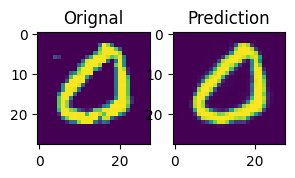

-----------------------Auto Encoder 2------------------------
Epoch=1, Train Loss=0.2644, Eval Loss=0.0895
Epoch=2, Train Loss=0.0684, Eval Loss=0.0542
Epoch=3, Train Loss=0.0528, Eval Loss=0.0493
Epoch=4, Train Loss=0.0501, Eval Loss=0.0482
Epoch=5, Train Loss=0.0492, Eval Loss=0.0469
Epoch=6, Train Loss=0.0487, Eval Loss=0.0459
Epoch=7, Train Loss=0.0484, Eval Loss=0.0468
Epoch=8, Train Loss=0.0482, Eval Loss=0.0469
Epoch=9, Train Loss=0.0481, Eval Loss=0.0465
Epoch=10, Train Loss=0.048, Eval Loss=0.047
Epoch=11, Train Loss=0.0479, Eval Loss=0.0453
Epoch=12, Train Loss=0.0479, Eval Loss=0.0463
Epoch=13, Train Loss=0.0477, Eval Loss=0.0455
Epoch=14, Train Loss=0.0477, Eval Loss=0.0456
Epoch=15, Train Loss=0.0477, Eval Loss=0.0457
Epoch=16, Train Loss=0.0476, Eval Loss=0.0458
Epoch=17, Train Loss=0.0476, Eval Loss=0.0464
Epoch=18, Train Loss=0.0476, Eval Loss=0.0454
Epoch=19, Train Loss=0.0476, Eval Loss=0.0457
Epoch=20, Train Loss=0.0475, Eval Loss=0.0459
-----------------------Classi

In [11]:
n_epochs=20

print("-----------------------Auto Encoder 1------------------------")
for i in range(n_epochs):
    train_loss=train_e1d1()
    eval_loss,x,pred=eval_e1d1()
    print("Epoch=", i+1,", Train Loss=",train_loss,", Eval Loss=",eval_loss,sep="")
    
plt.figure(figsize=(3.2,2.4))

r=torch.randint(low=0,high=pred.shape[0],size=(1,)).item()

plt.subplot(1,2,1)
plt.title("Orignal")
plt.imshow(torch.reshape(x[r],shape=(28,28)).cpu())

plt.subplot(1,2,2)
plt.title("Prediction")
plt.imshow(torch.reshape(pred[r],shape=(28,28)).cpu())
plt.show()
    
print("-----------------------Auto Encoder 2------------------------")
for i in range(n_epochs):
    print("Epoch=", i+1,", Train Loss=",train_e2d2(),", Eval Loss=",eval_e2d2(),sep="") 


print("-----------------------Classifier Only------------------------")
for i in range(n_epochs):
    print("Epoch=", i+1,", Train Loss & Accuracy=",train_clf(),", Eval Loss & Accuracy=",eval_clf(),sep="") 


print("--------------------Fine-Tuning Whole Metwork------------------")
for i in range(n_epochs):
    print("Epoch=", i+1,", Train Loss & Accuracy=",train_whole(),", Eval Loss & Accuracy=",eval_whole(),sep="")